In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import pearsonr



/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [2]:
data_splits = ["complete"]
data_dict = load_data(data_splits)

In [3]:
cp_features = infer_cp_features(data_dict["complete"])
cp_metadata = infer_cp_features(data_dict["complete"], metadata = True)
complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_metadata_df = data_dict["complete"].reindex(cp_metadata, axis="columns")

In [4]:
decoder_beta = keras.models.load_model("../2.train/models/level5Decoder_beta")
decoder_vanilla = keras.models.load_model("../2.train/models/level5Decoder_vanilla")
decoder_mmd = keras.models.load_model("../2.train/models/level5Decoder_mmd")
encoder_beta = keras.models.load_model("../2.train/models/level5Encoder_beta")
encoder_vanilla = keras.models.load_model("../2.train/models/level5Encoder_vanilla")
encoder_mmd = keras.models.load_model("../2.train/models/level5Encoder_mmd")

2022-01-11 20:27:06.971263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 20:27:06.971308: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 20:27:06.971341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2022-01-11 20:27:06.971601: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
reconstruction_vanilla = decoder_vanilla.predict(encoder_vanilla.predict(complete_features_df)[0])
reconstruction_beta = decoder_beta.predict(encoder_beta.predict(complete_features_df)[0])
reconstruction_mmd = decoder_mmd.predict(encoder_mmd.predict(complete_features_df)[0])

2022-01-11 20:27:08.933722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
correlation_vanilla = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_vanilla, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])
correlation_beta = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_beta, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])
correlation_mmd = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_mmd, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])


In [7]:
correlation_vanilla = correlation_vanilla.dropna()
correlation_vanilla = correlation_vanilla[correlation_vanilla.moa.str.contains('\|')]

correlation_beta = correlation_beta.dropna()
correlation_beta = correlation_beta[correlation_beta.moa.str.contains('\|')]

correlation_mmd = correlation_mmd.dropna()
correlation_mmd = correlation_mmd[correlation_mmd.moa.str.contains('\|')]



In [8]:
vanilla_moa_reproducibility = correlation_vanilla.groupby('moa').median()
beta_moa_reproducibility = correlation_beta.groupby('moa').median()
mmd_moa_reproducibility = correlation_mmd.groupby('moa').median()

In [9]:
vanilla_predictability = (pd.read_csv('per_moa_performance/level5_vanilla_moa_performance.csv').set_index('MOA')['zscore'])
beta_predictability = pd.read_csv('per_moa_performance/level5_beta_moa_performance.csv').set_index('MOA')['zscore']
mmd_predictability = pd.read_csv('per_moa_performance/level5_mmd_moa_performance.csv').set_index('MOA')['zscore']


In [10]:
vanilla = pd.concat([vanilla_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-vanilla_predictability))).assign(MOA = vanilla_predictability.index).set_index('MOA')], axis = 1)
beta = pd.concat([beta_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-beta_predictability))).assign(MOA = beta_predictability.index).set_index('MOA')], axis = 1)
mmd = pd.concat([mmd_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-mmd_predictability))).assign(MOA = mmd_predictability.index).set_index('MOA')], axis = 1)


In [11]:
vanilla = pd.concat([vanilla, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_vanilla.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)
beta = pd.concat([beta, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_beta.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)
mmd = pd.concat([mmd, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_mmd.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)

In [12]:
vanilla

,0,0,Unshuffled
11-beta hydroxysteroid dehydrogenase inhibitor|FXR agonist,0.967951,0.459438,0.988372
ACAT inhibitor|sterol regulatory element binding protein (SREBP) inhibitor,0.975993,NaN,NaN
AKT inhibitor|TRAIL modulator,0.989409,NaN,NaN
AKT inhibitor|mTOR inhibitor,0.897754,5.784977,0.960494
ATP channel activator|potassium channel activator,0.955367,NaN,NaN
...,...,...,...
potassium channel blocker|sodium channel blocker,0.940774,0.055730,0.900933
serotonin receptor agonist|serotonin receptor antagonist,0.980552,1.580207,0.984786
serotonin receptor antagonist|sodium channel blocker,0.941581,3.399883,0.936856
sodium channel blocker|T-type calcium channel blocker,0.985587,1.985945,0.986527


In [13]:
vanilla.columns = ['MOA reproducibility', 'Vanilla MOA pvalue', 'Vanilla MOA predictability']
beta.columns = ['MOA reproducibility', 'Beta MOA pvalue', 'Beta MOA predictability']
mmd.columns = ['MOA reproducibility', 'MMD MOA pvalue', 'MMD MOA predictability']

In [14]:
vanilla = vanilla.dropna()
beta = beta.dropna()
mmd = mmd.dropna()

In [15]:
sns.set(font_scale=.5)

<AxesSubplot:xlabel='MOA reproducibility', ylabel='MMD MOA predictability'>

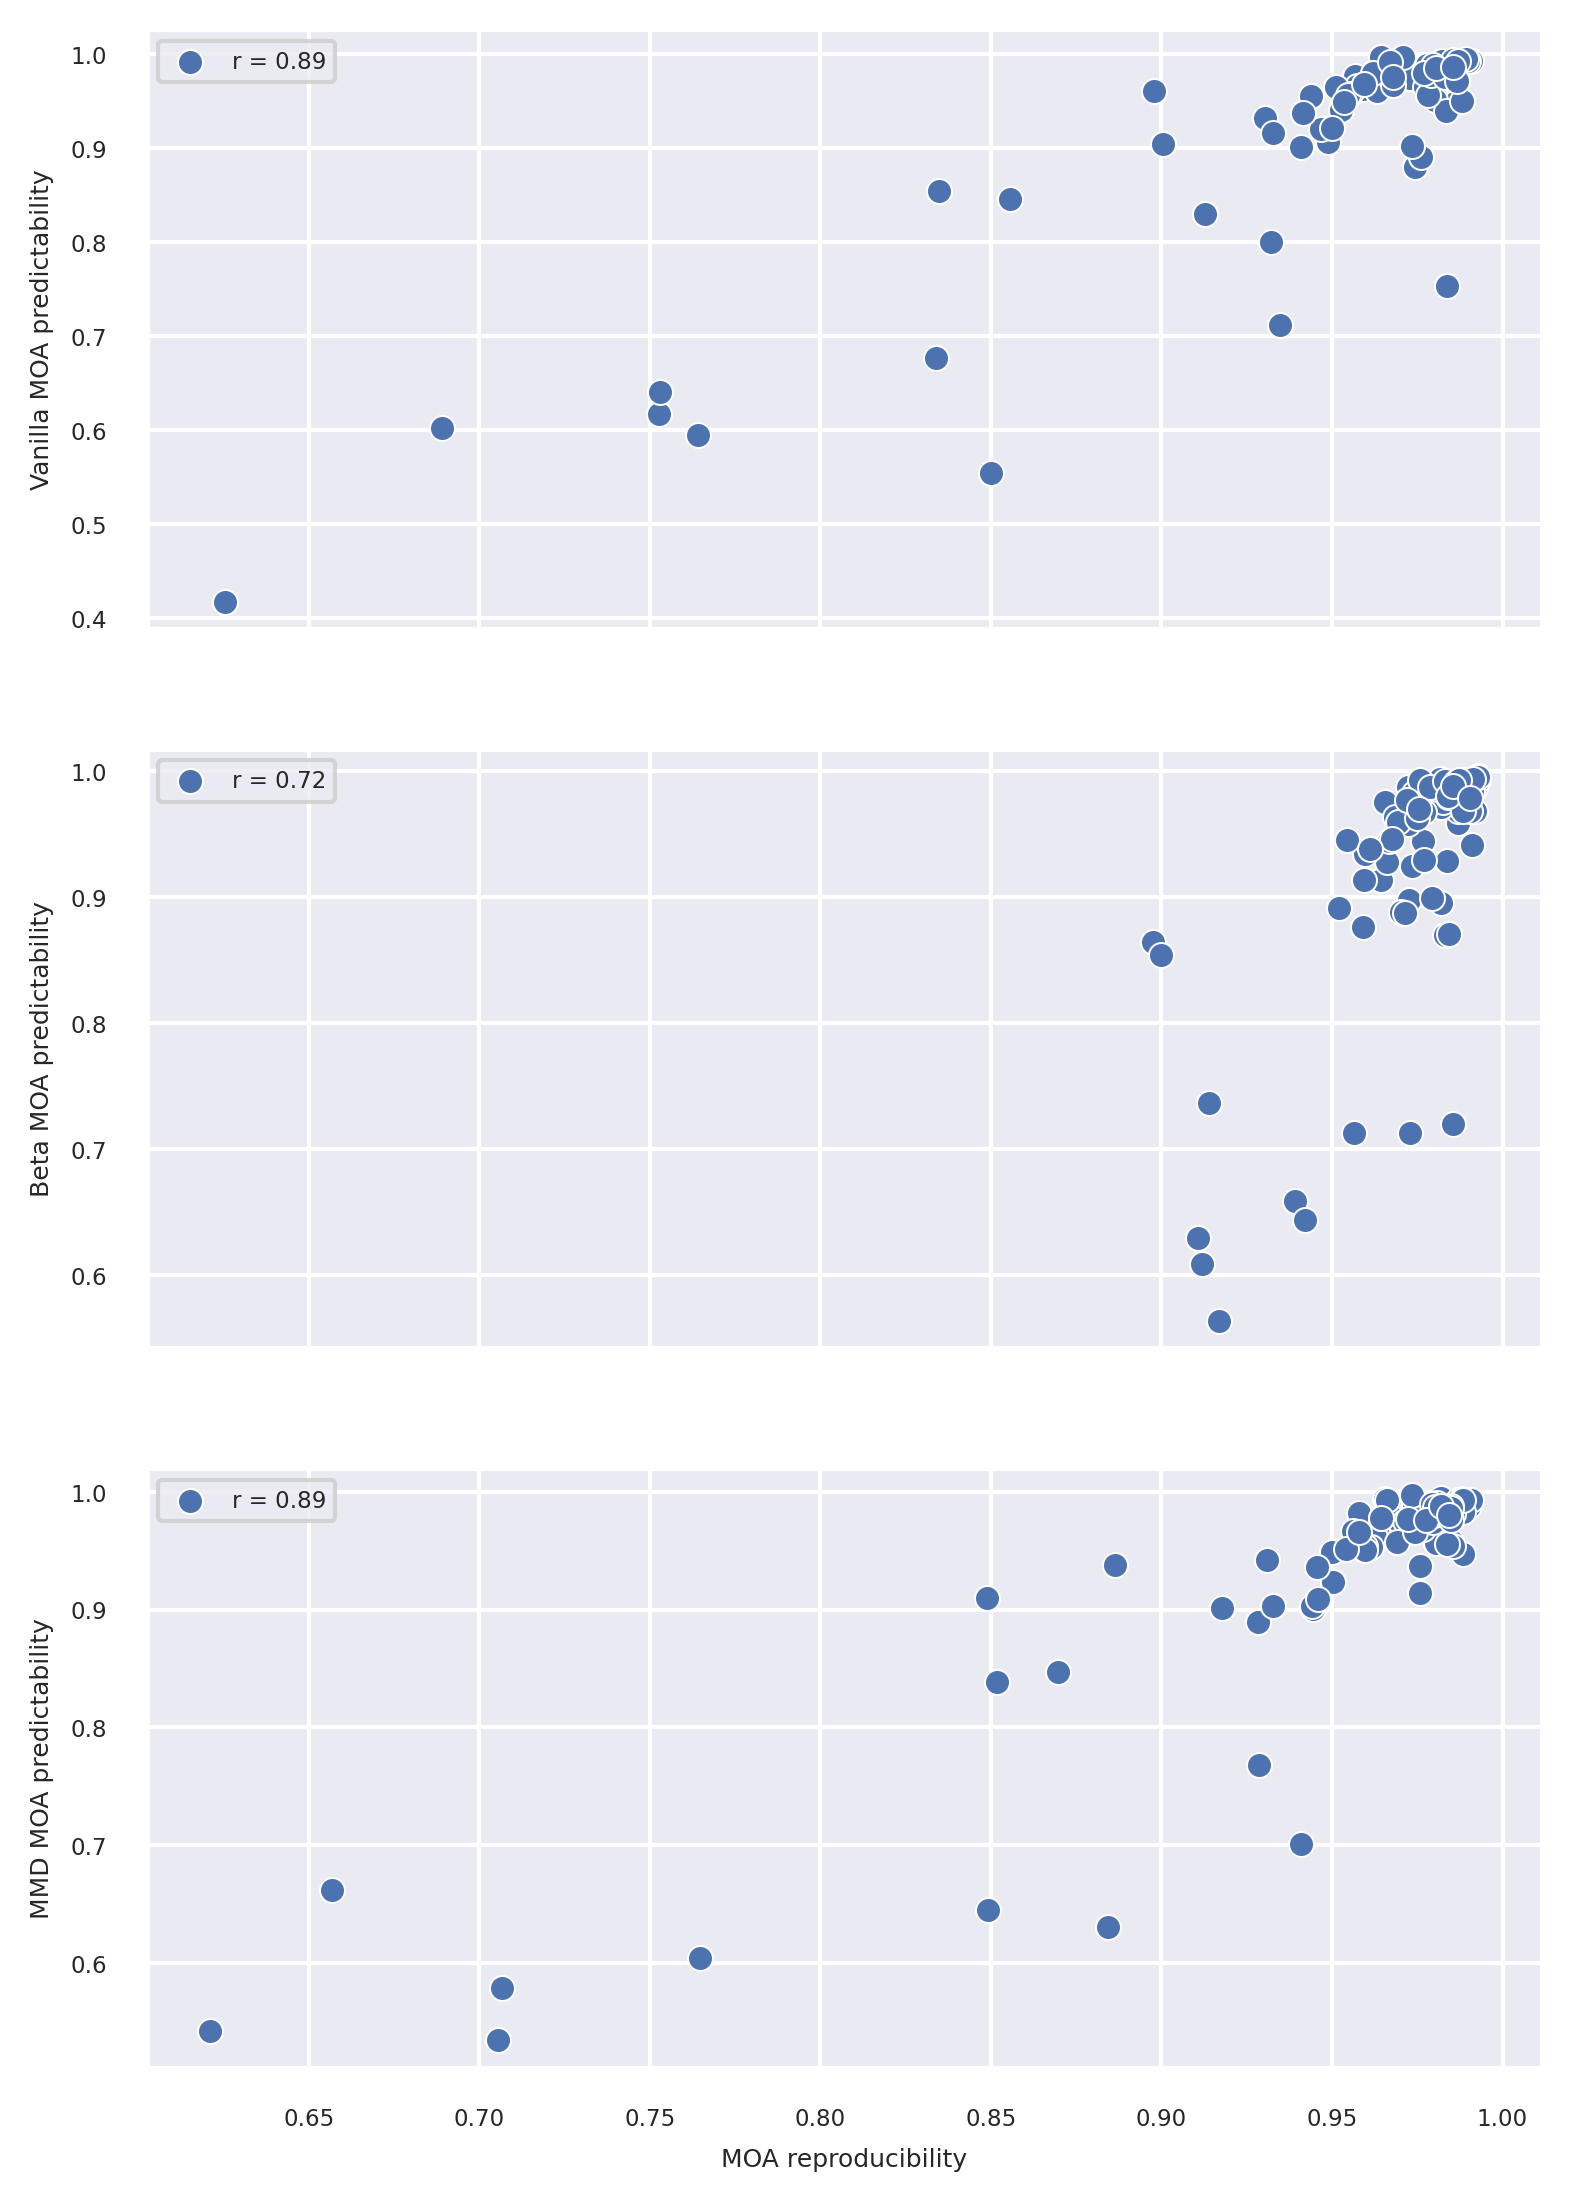

In [29]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3,1, figsize=(6, 9), dpi=300, sharex = True)
vcorr = pearsonr(vanilla['Vanilla MOA predictability'], vanilla['MOA reproducibility'])[0]
bcorr = pearsonr(beta['Beta MOA predictability'], beta['MOA reproducibility'])[0]
mcorr =pearsonr(mmd['MMD MOA predictability'], mmd['MOA reproducibility'])[0]
sns.scatterplot(ax = ax1, data = vanilla, x = 'MOA reproducibility', y = 'Vanilla MOA predictability', label = 'r = ' + str(round(vcorr, 2)))
sns.scatterplot(ax = ax2, data = beta, x = 'MOA reproducibility', y = 'Beta MOA predictability', label = 'r = ' + str(round(bcorr, 2)))
sns.scatterplot(ax = ax3, data = mmd, x = 'MOA reproducibility', y = 'MMD MOA predictability', label = 'r = ' + str(round(mcorr, 2)))



In [48]:
# fig, ((ax1, ax2, ax3)) = plt.subplots(3,1, figsize=(6, 9), dpi=300, sharex = True)
# sns.scatterplot(ax = ax1, data = vanilla, x = 'MOA reproducibility', y = 'pearson')
# sns.scatterplot(ax = ax2, data = beta, x = 'MOA reproducibility', y = 'pearson')
# sns.scatterplot(ax = ax3, data = mmd, x = 'MOA reproducibility', y = 'pearson')


In [ ]:
vanilla

In [ ]:
print(pearsonr(vanilla['pearson'], vanilla['MOA reproducibility'])[0])
print(pearsonr(beta['pearson'], beta['MOA reproducibility'])[0])
print(pearsonr(mmd['pearson'], mmd['MOA reproducibility'])[0])

In [ ]:
moa_groups = complete_features_df.assign(moa = pd.read_csv('moa_metadata.csv')['moa']).groupby('moa').mean()
mean = complete_features_df.mean()
distances = pd.DataFrame(np.linalg.norm(moa_groups - mean, axis = 1), columns = ['MOA distance to mean']).set_index(moa_groups.index)
distances

In [ ]:
df = pd.concat([distances, beta], axis = 1).dropna()

In [ ]:
fig, ax = plt.subplots(dpi=300, sharex = True)

sns.scatterplot(data = df, x = 'MOA distance to mean', y = 'Beta MOA predictability')